In [50]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 한 실행칸에 프린트 여러개 해도 다 출력시키도록 하는 코드.
from scipy.optimize import minimize
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import *

# Data Loading & preprocessing

In [51]:
_start = datetime(2015,1,1)
stock_list = ['005930.KS', '051910.KS', '005380.KS', '035420.KS', '017670.KS',
             '207940.KS', '068270.KS', '035720.KS', '006400.KS', '051900.KS']
row_data = pdr.get_data_yahoo(stock_list, start = _start)

In [52]:
row_data = row_data.xs('Close', axis = 1)

In [53]:
col_list = row_data.columns.to_list()
for i in col_list:
    row_data['logret_' + i[:-3]] = np.log(row_data[i] / row_data[i].shift(1)) * 100
    row_data.drop(i, axis = 1, inplace = True)
row_data
# kospi['log_ret'] = np.log(kospi['Adj Close'] / kospi['Adj Close'].shift(1))

Symbols     logret_005930  logret_051910  logret_005380  logret_035420  \
Date                                                                     
2015-01-02            NaN            NaN            NaN            NaN   
2015-01-05       0.225310      -3.103211      -0.593474       2.432552   
2015-01-06      -2.892135      -4.993695      -2.105341      -0.804294   
2015-01-07       0.922374      -0.907722       3.288787      -1.491553   
2015-01-08       0.534149       2.105341       4.598511       1.626052   
...                   ...            ...            ...            ...   
2020-10-08      -0.334448       1.749316      -1.375538      -1.320151   
2020-10-12       1.165708      -2.932762      -0.277393      -3.035646   
2020-10-13       0.824407      -4.255961      -0.557105       1.022155   
2020-10-14       0.000000      -2.515856      -0.560226       1.179458   
2020-10-15      -1.322333       0.950879      -0.281294      -1.010110   

Symbols     logret_017670  logret_207940  logret_068270  logret_035720  \
Date                                                                     
2015-01-02            NaN            NaN            NaN            NaN   
2015-01-05       1.457221            NaN      -0.512218       5.183979   
2015-01-06      -0.725956            NaN      -1.813543       0.552106   
2015-01-07      -1.838287            NaN      -0.919107       1.976214   
2015-01-08      -1.683856            NaN       0.526062      -0.609139   
...                   ...            ...            ...            ...   
2020-10-08      -0.415801      -0.835659       0.574164      -0.394997   
2020-10-12      -0.208551       0.557882       4.295712      -1.998734   
2020-10-13       1.244829       0.554786      -1.102952       0.134499   
2020-10-14      -5.075085      -2.237856      -3.192759      -0.945314   
2020-10-15       0.432901       0.845075      -1.151644      -1.366141   

Symbols     logret_006400  logret_051900  
Date                                      
2015-01-02            NaN            NaN  
2015-01-05      -1.724181      -1.302950  
2015-01-06      -3.540193      -0.657897  
2015-01-07      -0.451468      -0.995033  
2015-01-08       3.118293       2.143528  
...                   ...            ...  
2020-10-08       1.243657       1.768798  
2020-10-12      -1.129956       2.880199  
2020-10-13       1.242252      -2.362063  
2020-10-14      -1.583744      -0.129283  
2020-10-15      -1.725172      -1.105702  

[1416 rows x 10 columns]

In [54]:
today = datetime(datetime.today().year, datetime.today().month, datetime.today().day)
five_years_ago = today + relativedelta(years = -5)
row_data = row_data[row_data.index >= five_years_ago]

In [55]:
one_year_ago = today + relativedelta(years = -1)

In [56]:
train = row_data.loc[five_years_ago : one_year_ago]

In [57]:
cd91 = pd.read_csv('./CD91.csv')
cd91['rate'] = cd91['rate']/365 * 100 # 365(전체 일수), 252(영업 일수)
cd91['date'] = pd.to_datetime(cd91['date'])
cd91.set_index('date', inplace = True)
cd91.head()

rate
date                
2009-01-02  1.076712
2009-01-05  1.073973
2009-01-06  1.073973
2009-01-07  1.073973
2009-01-08  0.890411

In [58]:
data = row_data.join(cd91, how='left')
data.fillna(method = 'ffill', inplace = True)
data.fillna(method = 'bfill', inplace = True)
data.dropna(inplace = True)

In [59]:
date_list = data.loc[one_year_ago:].index.to_list()

In [60]:
cd91_for_1year = data.loc[date_list[0]:, ].iloc[1:,-1]
cd91_for_1year

Date
2019-10-16    0.372603
2019-10-17    0.372603
2019-10-18    0.372603
2019-10-21    0.372603
2019-10-22    0.372603
                ...   
2020-10-08    0.172603
2020-10-12    0.172603
2020-10-13    0.172603
2020-10-14    0.172603
2020-10-15    0.172603
Name: rate, Length: 247, dtype: float64

# Calculating the sample covariance matrix

In [61]:
vcov = train.cov()

In [62]:
vcov # sample covariance matrix

Symbols        logret_005930  logret_051910  logret_005380  logret_035420  \
Symbols                                                                     
logret_005930       2.564786       0.753039       0.159543       0.668498   
logret_051910       0.753039       3.933329       0.409352       0.470498   
logret_005380       0.159543       0.409352       3.013205       0.481673   
logret_035420       0.668498       0.470498       0.481673       3.614916   
logret_017670       0.037887       0.248710       0.201634      -0.000225   
logret_207940       0.523345       0.769002       0.317924       0.451348   
logret_068270       0.358144       0.766302       0.025795       0.678593   
logret_035720       0.618493       0.774121       0.239785       1.059232   
logret_006400       1.204109       2.163261       0.241326       0.392893   
logret_051900       0.197399       0.643152       0.254821       0.523578   

Symbols        logret_017670  logret_207940  logret_068270  logret_035720  \
Symbols                                                                     
logret_005930       0.037887       0.523345       0.358144       0.618493   
logret_051910       0.248710       0.769002       0.766302       0.774121   
logret_005380       0.201634       0.317924       0.025795       0.239785   
logret_035420      -0.000225       0.451348       0.678593       1.059232   
logret_017670       1.900836      -0.053466      -0.102737       0.090192   
logret_207940      -0.053466       9.195496       3.532435       1.253770   
logret_068270      -0.102737       3.532435       8.467411       1.441624   
logret_035720       0.090192       1.253770       1.441624       4.567289   
logret_006400       0.210530       1.130901       1.078073       0.771827   
logret_051900      -0.015106       0.683063       1.181153       0.591021   

Symbols        logret_006400  logret_051900  
Symbols                                      
logret_005930       1.204109       0.197399  
logret_051910       2.163261       0.643152  
logret_005380       0.241326       0.254821  
logret_035420       0.392893       0.523578  
logret_017670       0.210530      -0.015106  
logret_207940       1.130901       0.683063  
logret_068270       1.078073       1.181153  
logret_035720       0.771827       0.591021  
logret_006400       5.683600       0.651741  
logret_051900       0.651741       4.409065

sample covariance matrix를 위와 같이 뽑을 수 있다.

<Figure size 1080x1080 with 0 Axes>

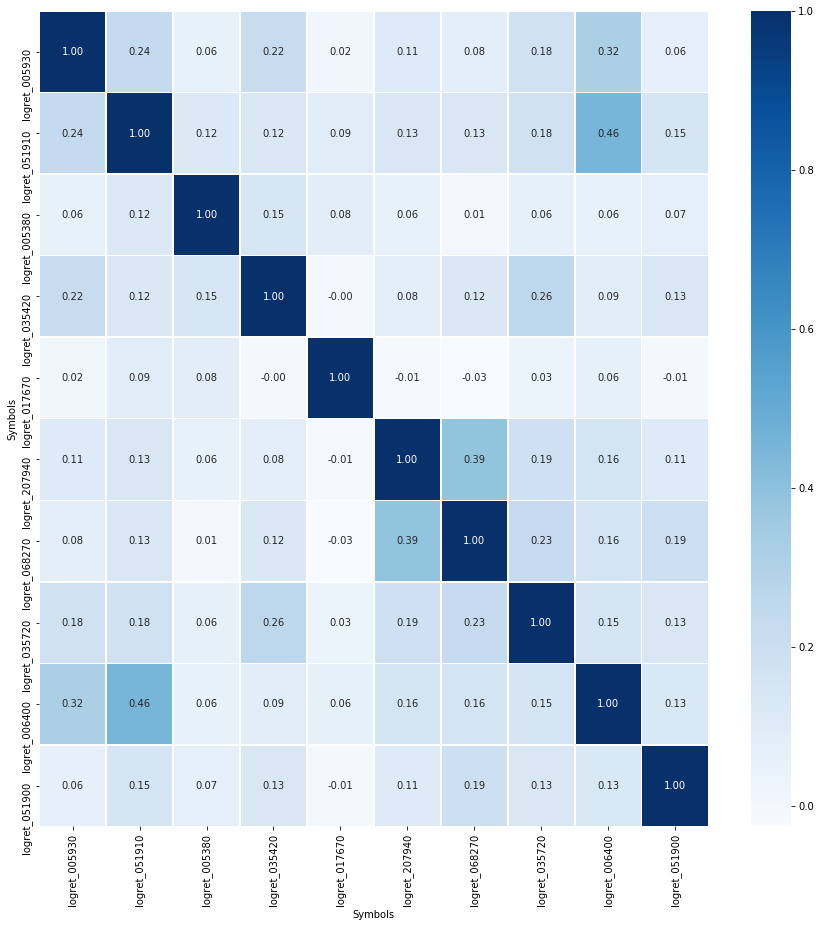

In [63]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True,
            fmt = '.2f', linewidths=.5, cmap='Blues') # heatmap of correlation matrix

In [64]:
n = len(row_data)
p = len(row_data.columns)

# Minimum variance portfolio

In [65]:
def constraint1(x):
    _sum = 0
    for i in range(len(x)):
        _sum += np.abs(x[i])
    return -(_sum - c)
    
    
def constraint2(x):
    _sum = 0
    for i in range(len(x)):
        _sum += x[i]
    return _sum - 1
    

In [66]:
def obj_func(x):
    return -x.T @ vcov @ x

In [67]:
vcov = None
c = None
cons = [{'type': 'ineq', 'fun': constraint1},
        {'type': 'eq', 'fun': constraint2}]
def minimum_var_pf(data, _vcov = None, constraints = 1): # data : train data, vcov = variance-covariance matrix
    # constraints = 1 : No short sale
    global vcov, c
    c = constraints
    if _vcov is None:
        vcov = data.cov()
    else:
        vcov = _vcov
    inv_vcov = np.linalg.inv(vcov)
    w = inv_vcov @ np.ones(len(vcov))
    res = minimize(obj_func, w, constraints = cons, options = {'maxiter' : 10})
    w = res.x
    return w


In [68]:
minimum_var_pf(train)

array([ 6.38782457e-01, -1.09862182e-04,  1.19466883e-01,  1.89924864e-02,
        3.80365045e-01, -6.48416767e-02, -5.24953568e-02, -1.03010910e-02,
       -5.64561805e-02,  2.65972958e-02])

now, repeat the above process with moving window for 1 year

In [69]:
data.loc[:date_list[1],:].iloc[1:,:-1]

logret_005930  logret_051910  logret_005380  logret_035420  \
Date                                                                     
2015-10-16      -0.315707       0.520383      -0.927364       3.114439   
2015-10-19      -0.714005       0.517689       0.000000      -0.512384   
2015-10-20       0.793026       0.000000       0.927364      -1.032711   
2015-10-21       0.315458       1.197619       0.307220      -0.520383   
2015-10-22       0.784318      -1.197619      -0.615387      -4.992124   
...                   ...            ...            ...            ...   
2019-10-10      -0.718320       0.506330      -2.343857       0.000000   
2019-10-11       1.228265       1.834914      -0.396040       1.615544   
2019-10-14       1.714616       0.494642      -3.226086       0.000000   
2019-10-15       0.199800      -0.329490       0.000000      -2.927038   
2019-10-16       1.190490       0.000000       0.816331       1.960847   

            logret_017670  logret_207940  logret_068270  logret_035720  \
Date                                                                     
2015-10-16      -0.386848      11.469184       3.441432      -0.778888   
2015-10-19       0.964328      11.469184       4.885551       0.260304   
2015-10-20      -0.384616      11.469184      -0.129031       0.518584   
2015-10-21       0.192493      11.469184       0.000000      -0.518584   
2015-10-22      -3.323864      11.469184      -2.879760      -2.812136   
...                   ...            ...            ...            ...   
2019-10-10      -0.854706      -0.916037       0.276514       1.476042   
2019-10-11       1.490975      -0.307220       0.275752      -1.104984   
2019-10-14       0.000000       1.375117       0.549809      -0.371058   
2019-10-15       0.632247      -1.067897       0.546230      -0.372440   
2019-10-16      -0.421053       3.910273       1.889207      -1.503788   

            logret_006400  logret_051900  
Date                                      
2015-10-16      -2.777956       2.136113  
2015-10-19       6.805346      -0.445932  
2015-10-20       3.871451       1.662088  
2015-10-21       0.421053       0.875279  
2015-10-22      -4.292504      -0.546151  
...                   ...            ...  
2019-10-10       2.614528      -2.454111  
2019-10-11      -2.394021      -1.250016  
2019-10-14      -0.220507      -0.789270  
2019-10-15      -2.911740       2.116896  
2019-10-16      -0.684153      -0.233010  

[974 rows x 10 columns]

In [70]:
min_pf_ret = np.zeros((3, len(date_list)-1))
for idx, i in enumerate(date_list[:-1]):
    _data = data.loc[:i,:].iloc[idx:,:-1]
    target_data = data.loc[date_list[idx+1],:][:-1]
    print(i)
    _vcov = _data.cov()
    for j in range(3):
        weight = minimum_var_pf(_data, _vcov, constraints = j+1) # (10, 1)
        _ret = target_data @ weight
        min_pf_ret[j][idx] = _ret       

2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-15 00:00:00
2019-11-18 00:00:00
2019-11-19 00:00:00
2019-11-20 00:00:00
2019-11-21 00:00:00
2019-11-22 00:00:00
2019-11-25 00:00:00
2019-11-26 00:00:00
2019-11-27 00:00:00
2019-11-28 00:00:00
2019-11-29 00:00:00
2019-12-02 00:00:00
2019-12-03 00:00:00
2019-12-04 00:00:00
2019-12-05 00:00:00
2019-12-06 00:00:00
2019-12-09 00:00:00
2019-12-10 00:00:00
2019-12-11 00:00:00
2019-12-12 00:00:00
2019-12-13 00:00:00
2019-12-16 00:00:00
2019-12-17 00:00:00
2019-12-18 00:00:00
2019-12-19 00:00:00
2019-12-20 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00


# Calculating the portfolio's variance and sharpe ratio

In [71]:
where_are_NaNs = isnan(min_pf_ret)
min_pf_ret[where_are_NaNs] = 0
min_pf_ret

array([[-3.92666599e+05,  7.96602859e+05, -7.91886175e-01,
         2.05935592e+05,  7.57853736e-01, -6.61435975e+05,
        -6.48619156e+04, -1.05711915e+05, -8.11304620e-02,
        -6.91337365e-01,  3.44497169e+12,  4.89917820e-01,
         9.86903731e-01,  9.70320340e-01,  8.08879522e-01,
         4.29803788e-01,  5.52186917e-01, -7.57027844e-01,
        -9.37887531e-01,  1.73560379e+00, -5.52609308e-01,
         1.62009507e+00, -7.90840415e+03,  1.77024173e+05,
        -1.39065127e+08, -1.01157713e+00,  1.70734331e+05,
         4.91559507e-01, -6.43672513e-01,  4.22081437e-01,
        -3.12161065e-01, -1.40588546e+00, -5.54380610e-01,
        -5.68474652e-01, -6.05120455e-01, -1.89848994e+05,
         1.20032385e+00,  1.37850611e+00,  1.05240113e+05,
         7.48206535e+04,  1.31828984e+00,  1.39999611e+00,
         8.35222825e-02, -5.92855419e+04, -1.83318559e+05,
        -2.00873812e-01, -1.61544413e+04, -1.31936881e+00,
        -6.30083931e-01, -5.83947157e+04, -1.99277145e+0

In [72]:
min_pf_var_1 = min_pf_ret[0].var()
min_pf_var_2 = min_pf_ret[1].var()
min_pf_var_3 = min_pf_ret[0].var()

min_pf_sharpe_1 = (min_pf_ret[0] - cd91_for_1year).mean()/min_pf_var_1
min_pf_sharpe_2 = (min_pf_ret[1] - cd91_for_1year).mean()/min_pf_var_2
min_pf_sharpe_3 = (min_pf_ret[2] - cd91_for_1year).mean()/min_pf_var_3

In [73]:
print('Variance of Minimum variance portfolio with gross-exposure constraints = 1 :', min_pf_var_1)
print('Variance of Minimum variance portfolio with gross-exposure constraints = 2 :', min_pf_var_2)
print('Variance of Minimum variance portfolio with gross-exposure constraints = 3 :', min_pf_var_3)

Variance of Minimum variance portfolio with gross-exposure constraints = 1 : 4.790064545877301e+22
Variance of Minimum variance portfolio with gross-exposure constraints = 2 : 7.035955721735195e+28
Variance of Minimum variance portfolio with gross-exposure constraints = 3 : 4.790064545877301e+22


In [74]:
print('Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 1 :', min_pf_sharpe_1)
print('Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 2 :', min_pf_sharpe_2)
print('Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 3 :', min_pf_sharpe_3)

Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 1 : 2.8715500445385955e-13
Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 2 : 1.4987080202247512e-16
Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 3 : -5.5512650846615953e-11


sharpe ratio가 좋지 않다. 아마 선택된 종목의 차이인 것으로 보여진다.

# Thresholded covariance

In [75]:
def thresh_cov(data, h = 2): # data : Train data
    vcov = data.cov() # variance covariance matrix
    n, p = data.shape
    theta = np.zeros((p, p))
    # train_mean_np = data.mean(axis = 0).to_numpy()
    # data_mean = train_mean_np.reshape(1, -1).repeat(len(data), axis = 0)
    # center_x = data - data_mean
    center_x = data - data.mean()
    for i in range(p-1):
        for j in range(i+1, p):
            theta[i][j] = ((center_x.iloc[:,i] * center_x.iloc[:,j] - vcov.iloc[i,j])**2).mean()
    theta = theta + theta.T
    Index = vcov/np.sqrt(theta) > 2 * np.sqrt(np.log(p)/n)
    for i in range(p):
        Index.iloc[i,i] = True
    vcov_thresh = vcov * Index
    return vcov_thresh

In [76]:
minimum_var_pf(train, thresh_cov(train)) # an example of weights

array([ 6.50353045e-01, -3.23434836e-04,  1.69856080e-01, -1.06780026e-04,
        4.04000480e-01, -8.35692577e-02, -1.17829716e-01,  3.30465660e-04,
       -3.19998627e-02,  9.28898026e-03])

now, repeat the above process with moving window for 1 year

In [77]:
thres_pf_ret = np.zeros((3, len(date_list)-1))
for idx, i in enumerate(date_list[:-1]):
    _data = data.loc[:i,:].iloc[idx:,:-1]
    target_data = data.loc[date_list[idx+1],:][:-1]
    print(i)
    _vcov = _data.cov()
    for j in range(3):
        weight = minimum_var_pf(_data, thresh_cov(_data), constraints = j+1) # (10, 1)
        _ret = target_data @ weight
        thres_pf_ret[j][idx] = _ret       

2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-15 00:00:00
2019-11-18 00:00:00
2019-11-19 00:00:00
2019-11-20 00:00:00
2019-11-21 00:00:00
2019-11-22 00:00:00
2019-11-25 00:00:00
2019-11-26 00:00:00
2019-11-27 00:00:00
2019-11-28 00:00:00
2019-11-29 00:00:00
2019-12-02 00:00:00
2019-12-03 00:00:00
2019-12-04 00:00:00
2019-12-05 00:00:00
2019-12-06 00:00:00
2019-12-09 00:00:00
2019-12-10 00:00:00
2019-12-11 00:00:00
2019-12-12 00:00:00
2019-12-13 00:00:00
2019-12-16 00:00:00
2019-12-17 00:00:00
2019-12-18 00:00:00
2019-12-19 00:00:00
2019-12-20 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00


In [78]:
where_are_NaNs = isnan(thres_pf_ret)
thres_pf_ret[where_are_NaNs] = 0
thres_pf_ret

array([[ 2.59105085e-02, -1.99787140e-01, -4.09023027e+04,
         3.47540429e-01,  5.60373608e-01, -8.80272947e+01,
        -1.15091438e-01, -4.67379388e-01, -2.28174127e-01,
        -6.63281972e-01, -7.70249696e-01,  6.45459233e-01,
         1.10057399e+00,  9.83979492e-01,  1.00356689e+00,
         4.10630604e-01,  5.81118851e-01, -6.01705981e-01,
        -6.36213658e+01,  1.87349888e+00, -3.85169430e-01,
         1.30602162e+00, -1.39872517e-01,  4.77301223e-02,
        -1.61532915e+00, -9.75688646e-01,  1.35696180e+00,
         2.96186519e-01, -6.84543930e-01,  5.22203212e-01,
        -3.37831299e-01, -1.42876842e+00, -6.16387712e-01,
        -5.46605631e-01, -4.35874501e-01, -8.07807300e-01,
         1.14118295e+00,  1.40607356e+00,  4.68107370e-01,
         4.32106558e-01,  1.26724092e+00,  1.48662547e+00,
        -8.27471972e-02,  2.02225419e+00,  2.06791661e-01,
        -2.06606170e-01,  8.60064174e-02, -1.33498925e+00,
        -6.02903572e-01,  8.41636815e-01, -1.26969830e+0

In [79]:
thres_pf_var_1 = thres_pf_ret[0].var()
thres_pf_var_2 = thres_pf_ret[1].var()
thres_pf_var_3 = thres_pf_ret[0].var()

thres_pf_sharpe_1 = (thres_pf_ret[0] - cd91_for_1year).mean()/thres_pf_var_1
thres_pf_sharpe_2 = (thres_pf_ret[1] - cd91_for_1year).mean()/thres_pf_var_2
thres_pf_sharpe_3 = (thres_pf_ret[2] - cd91_for_1year).mean()/thres_pf_var_3

In [80]:
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 1 :', thres_pf_var_1)
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 2 :', thres_pf_var_2)
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 3 :', thres_pf_var_3)

Variance of Thresholded covariance portfolio with gross-exposure constraints = 1 : 7.462853956949237e+27
Variance of Thresholded covariance portfolio with gross-exposure constraints = 2 : 3.275453736918753e+26
Variance of Thresholded covariance portfolio with gross-exposure constraints = 3 : 7.462853956949237e+27


In [81]:
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 1 :', thres_pf_sharpe_1)
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 2 :', thres_pf_sharpe_2)
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 3 :', thres_pf_sharpe_3)

Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 1 : -9.913377890314003e-16
Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 2 : 4.140828449012958e-15
Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 3 : -5.932548256181954e-16


sharpe ratio가 좋지 않다. 아마 선택된 종목의 차이인 것으로 보여진다.

# POET

In [82]:
def poet(data, num_eigen, _lambda = 1):
    vcov = data.cov()
    eigen_value, eigen_vector = np.linalg.eig(vcov) # Eigen value & Eigen vector
    factor_cov = eigen_vector[:,:num_eigen] @ np.diag(eigen_value[:num_eigen]) @ eigen_vector[:,:num_eigen].T
    sparse_input = vcov - factor_cov
    idx = np.zeros((p,p))

    #idx = i 변수와 j변수의 correlation의 절대값이 lambda보다 크면 1, 아니면 0
    for i in range(p):
        for j in range(p):
            idx[i][j] = 0
            if sparse_input.iloc[i,j]/np.sqrt(sparse_input.iloc[i,i]*sparse_input.iloc[j,j]) >= _lambda:
                idx[i][j] = 1
    sparse_cov = sparse_input*idx
    
    return factor_cov + sparse_cov

In [83]:
minimum_var_pf(train, poet(train, 5))

array([ 105246.75919158,  -45592.46526874,   40478.41985618,
        -74293.73065124,   41458.26045277,  -52698.26637365,
       -166386.18888066,   26922.71036812,  -62181.90550128,
        187047.40680693])

now, repeat the above process with moving window for 1 year

In [ ]:
poet_pf_ret = np.zeros((3, len(date_list)-1))
for idx, i in enumerate(date_list[:-1]):
    _data = data.loc[:i,:].iloc[idx:,:-1]
    target_data = data.loc[date_list[idx+1],:][:-1]
    print(i)
    _vcov = _data.cov()
    for j in range(3):
        weight = minimum_var_pf(_data, poet(_data, 5), constraints = j+1) # (10, 1)
        _ret = target_data @ weight
        poet_pf_ret[j][idx] = _ret       

2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-15 00:00:00
2019-11-18 00:00:00
2019-11-19 00:00:00
2019-11-20 00:00:00
2019-11-21 00:00:00
2019-11-22 00:00:00
2019-11-25 00:00:00
2019-11-26 00:00:00
2019-11-27 00:00:00
2019-11-28 00:00:00
2019-11-29 00:00:00
2019-12-02 00:00:00
2019-12-03 00:00:00
2019-12-04 00:00:00
2019-12-05 00:00:00
2019-12-06 00:00:00
2019-12-09 00:00:00
2019-12-10 00:00:00
2019-12-11 00:00:00
2019-12-12 00:00:00
2019-12-13 00:00:00
2019-12-16 00:00:00
2019-12-17 00:00:00
2019-12-18 00:00:00
2019-12-19 00:00:00
2019-12-20 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00


In [ ]:
where_are_NaNs = isnan(poet_pf_ret)
poet_pf_ret[where_are_NaNs] = 0
poet_pf_ret

In [ ]:
poet_pf_var_1 = poet_pf_ret[0].var()
poet_pf_var_2 = poet_pf_ret[1].var()
poet_pf_var_3 = poet_pf_ret[0].var()

poet_pf_sharpe_1 = (poet_pf_ret[0] - cd91_for_1year).mean()/poet_pf_var_1
poet_pf_sharpe_2 = (poet_pf_ret[1] - cd91_for_1year).mean()/poet_pf_var_2
poet_pf_sharpe_3 = (poet_pf_ret[2] - cd91_for_1year).mean()/poet_pf_var_3

In [ ]:
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 1 :', poet_pf_var_1)
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 2 :', poet_pf_var_2)
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 3 :', poet_pf_var_3)

In [ ]:
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 1 :', poet_pf_sharpe_1)
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 2 :', poet_pf_sharpe_2)
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 3 :', poet_pf_sharpe_3)

sharpe ratio가 좋지 않다. 아마 선택된 종목의 차이인 것으로 보여진다.